In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np


In [2]:
exptnames = ['ReLU', 'JumpReLU', 'TopK', 'SpaDE']
results_all = []
for i in range(len(exptnames)):
    results_all.append(torch.load('./results2/'+exptnames[i]+'_results.pt', map_location=torch.device('cpu')))

/tmp/ipykernel_1416477/2574205173.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_all.append(torch.load('./results2/'+exptnames[i]+'_results.pt', map_location=to

In [3]:
results_all[0]['sae_decoder_bias'].shape

torch.Size([1, 128])

In [4]:
#load data subset
data_subset = []
labels_subset = []
numpoints_perconc = []
concept_names = []
for lab, key in enumerate(results_all[0]['pos_acts'].keys()):
    concept_names.append(key)
    data_subset.append(results_all[0]['pos_acts'][key])
    numpoints_perconc.append(data_subset[lab].shape[0])
    labels_subset.append(lab*torch.ones((numpoints_perconc[-1],)))
data_subset = torch.cat(data_subset, dim=0)
labels_subset = torch.cat(labels_subset)
num_concepts = len(concept_names)

In [5]:
#pca of data_subset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_subset)
data_subset_pca = pca.transform(data_subset)
encweightspca = [pca.transform(results_all[i]['sae_encoder_weights'].detach().numpy()) for i in range(len(exptnames))]
preencbiaspca = [pca.transform(results_all[i]['sae_decoder_bias'].detach().numpy()) for i in range(len(exptnames))]

In [6]:
#load latent reps
latent_reps_all = []
for i in range(len(exptnames)):
    latentsi = []
    for lab,key in enumerate(results_all[i]['latents_to_acts'].keys()):
        latentsi.append(results_all[i]['latents_to_acts'][key])
    latent_reps_all.append(torch.cat(latentsi, dim=0))

In [7]:
#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[i].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c, :], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
concepts_ordered_all = []
numlatents_perconc_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)
    concepts_ordered_all.append(concepts_of_latents[order_by_concept])
    numlatents_perconc_all.append([torch.sum(concepts_of_latents==c).item() for c in range(num_concepts)])


In [8]:
Cdata_all = []
Clatent_all = []
for i in range(len(exptnames)):
    Cdata_all.append(results_all[i]['acts_corrmap'])
    clatent = results_all[i]['latents_corrmap']
    clatent = clatent[order_by_concept_all[i], :]
    clatent = clatent[:, order_by_concept_all[i]]
    Clatent_all.append(clatent)

In [ ]:
eps = 1e-12

f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))
l0_all = torch.zeros((len(exptnames)))

for i in range(len(exptnames)):
    latents_i = latent_reps_all[i]
    # threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
    threshold = 1e-6
    l0_all[i] = (latents_i>threshold).sum(dim=-1).float().mean()
    for c in range(num_concepts):
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)

ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

In [9]:
# #alter- do spectral clustering on latents

# stableranks = []
# for i in range(len(exptnames)):
#     sr = torch.trace(Clatent_all[i])/torch.linalg.matrix_norm(Clatent_all[i], ord=2)
#     stableranks.append(sr.item())

# from sklearn.cluster import spectral_clustering as sc

# latent_order_all_sc = []
# sc_labels_all = []
# for i in range(len(exptnames)):
#     n_clusters = math.ceil(stableranks[i])
#     labels = sc(Clatent_all[i].cpu().numpy(), n_clusters=n_clusters, random_state=0)
#     labels = torch.tensor(labels)
#     sc_labels_all.append(labels)
#     order = torch.argsort(labels)
#     latent_order_all_sc.append(order)

# #for every experiment, for every label (group of latents), get the maximally activating concept
# concept_maxact_all = []
# for i in range(len(exptnames)):
#     nclusters_sc = math.ceil(stableranks[i])
#     concept_maxact = torch.zeros((nclusters_sc,))
#     for c in range(nclusters_sc):
#         concept_maxact[c] = 0
#         for q in range(num_concepts):
#             act_concq = torch.mean(latent_reps_all[i][:, sc_labels_all[i]==c], dim=-1)[labels_subset==q].mean()
#             if act_concq > concept_maxact[c]:
#                 concept_maxact[c] = q
#     concept_maxact_all.append(concept_maxact)

In [11]:
#pca of data_subset
from sklearn.decomposition import PCA
pca3 = PCA(n_components=3)
pca3.fit(data_subset)
data_subset_pca3 = pca3.transform(data_subset)
encweightspca3 = [pca3.transform(results_all[i]['sae_encoder_weights'].detach().numpy()) for i in range(len(exptnames))]
preencbiaspca3 = [pca3.transform(results_all[i]['sae_decoder_bias'].detach().numpy()) for i in range(len(exptnames))]

In [40]:
pca3.explained_variance_ratio_

array([0.48176373, 0.17743312, 0.12954782])

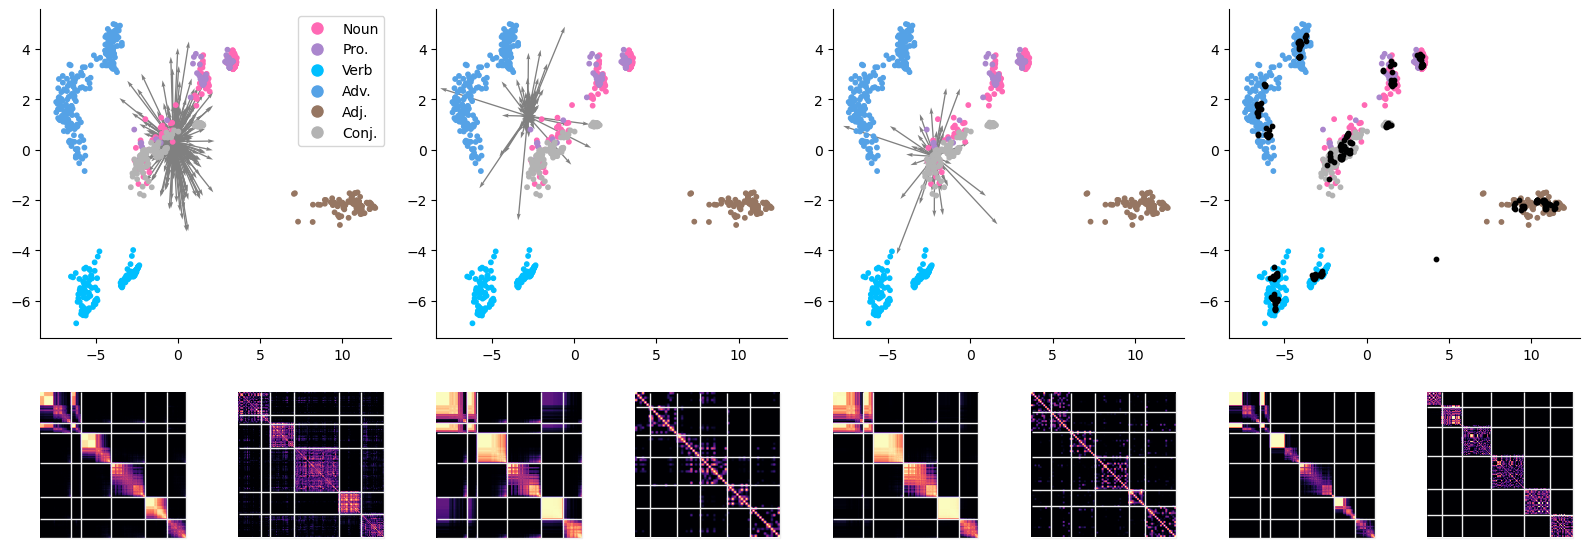

In [10]:
import matplotlib.gridspec as gridspec

# Scaling factor for figure size
scaleval = 2  # Adjust this as needed
fig = plt.figure(figsize=(scaleval * 8, scaleval * 3))

# Define the GridSpec layout (5 rows, 8 columns)
gs = gridspec.GridSpec(3, 8, figure=fig, height_ratios=[0.7, 0.7, 1])

# Define subplots using GridSpec, mirroring the subplot2grid layout
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0:2, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0:2, 4:6], sharey=ax1)
ax4 = fig.add_subplot(gs[0:2, 6:8], sharey=ax1)

ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 2])
ax7 = fig.add_subplot(gs[2, 4])
ax8 = fig.add_subplot(gs[2,6])

ax9 = fig.add_subplot(gs[2, 1])
ax10 = fig.add_subplot(gs[2, 3])
ax11 = fig.add_subplot(gs[2, 5])
ax12 = fig.add_subplot(gs[2, 7])

axes = np.array([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12]])
ax = axes.T


# fig, ax = plt.subplots(3, 4, figsize=(3*4, 3*3))
# ax = ax.T
# cmap = plt.cm.rainbow
# colors_concepts = [cmap.colors[i] for i in range(num_concepts)]
# get 10 colors from a colormap
cmap = plt.get_cmap('tab20')
scales_all = [20, 100,100, -1]
import numpy as np
# Generate 10 evenly spaced colors
# colors_concepts = [cmap(i) for i in np.linspace(0, 1, num_concepts)]
pos_colors = {
    'Noun': [1.        , 0.41176471, 0.70588235], 
    'Pro.': [0.66666667, 0.52418301, 0.80392157], 
    'Verb': [0.        , 0.74901961, 1. ], 
    'Adv.': [0.33333333, 0.63660131, 0.90196078], 
    'Adj.': [0.5882352941176471, 0.4627450980392157, 0.3843137254901961], 
    'Conj.': [0.7, 0.7, 0.7], 
    }
colors_concepts = [pos_colors[concept_names[i]] for i in range(num_concepts)]
for i in range(len(exptnames)):
    if i==len(exptnames)-1:
        ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], c=[colors_concepts[int(labels_subset[j].item())] for j in range(len(labels_subset))], s=10)
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], c='black', s=10)
    else:
        ax[i,0].quiver(preencbiaspca[i][0,0]*torch.ones((encweightspca[i].shape[0],)), preencbiaspca[i][0,1]*torch.ones((encweightspca[i].shape[0],)), encweightspca[i][:,0], encweightspca[i][:,1], color='gray', scale=scales_all[i], scale_units='xy', angles='xy')
        ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], c=[colors_concepts[int(labels_subset[j].item())] for j in range(len(labels_subset))], s=10)
    
    ax[i, 1].imshow(Cdata_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    ax[i, 2].imshow(Clatent_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    # ax[i,0].set_xticks([])
    # ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    # ax[i,1].set_xticks([])
    # ax[i,1].set_yticks([])
    # ax[i,2].set_xticks([])
    # ax[i,2].set_yticks([])
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_concepts[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

for ax in axes.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
# plt.savefig('./figs/formallanguagefig.pdf',dpi=300,bbox_inches='tight')

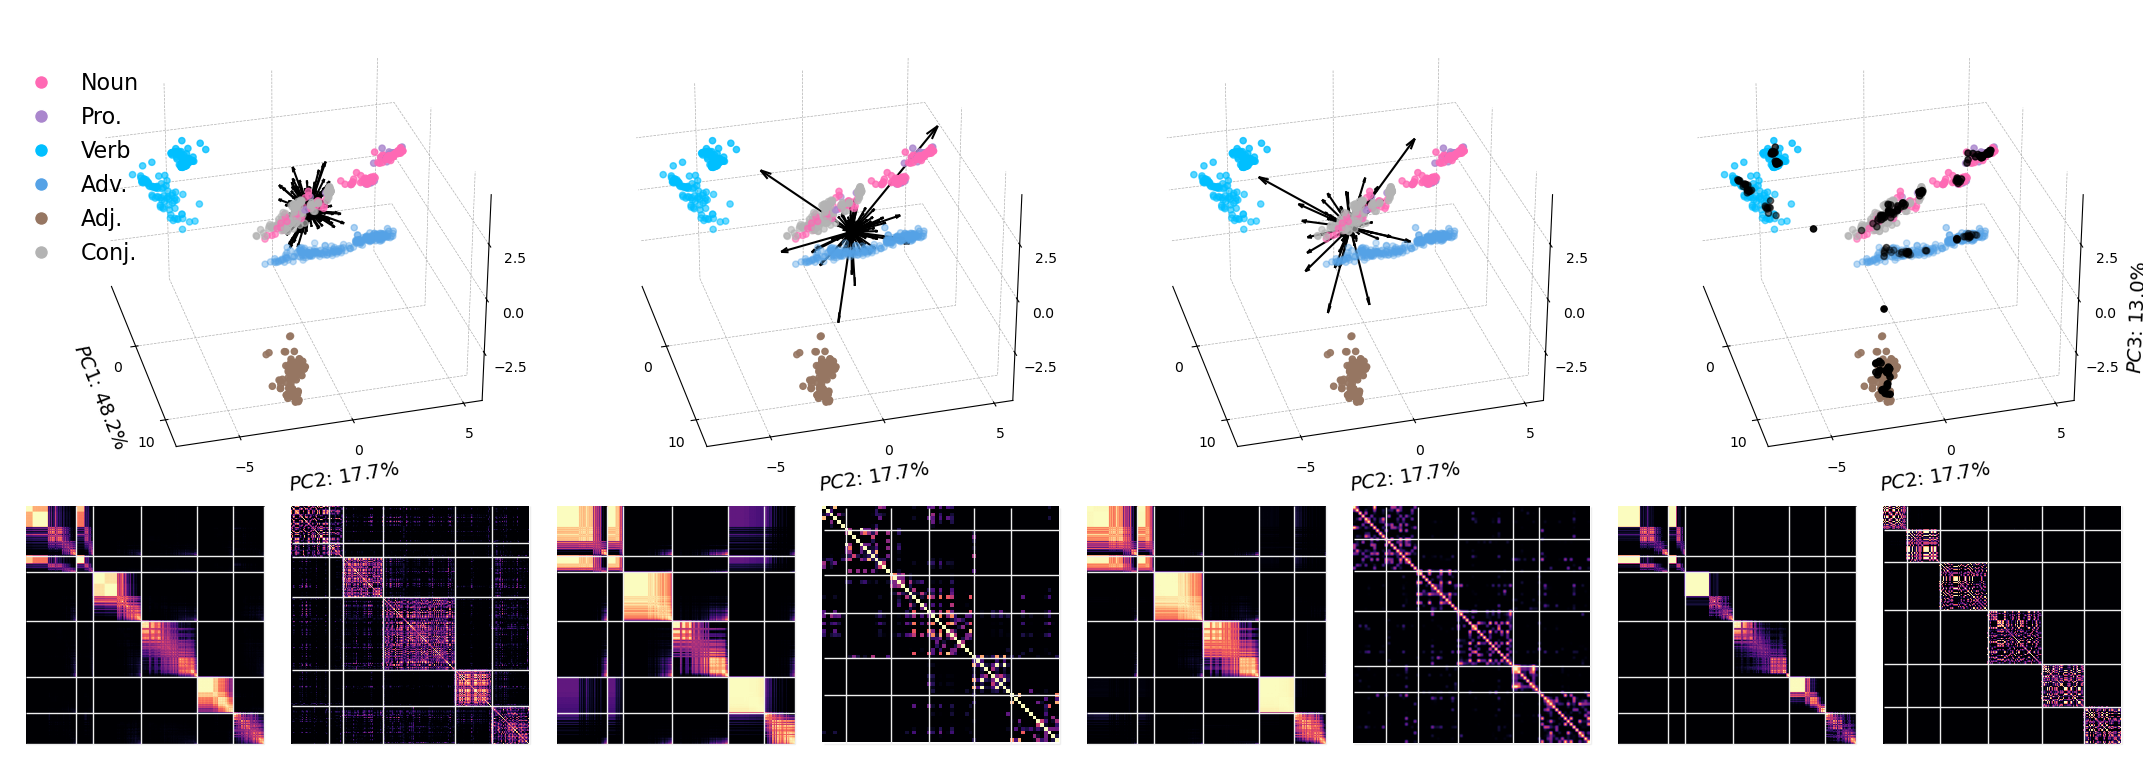

In [ ]:
import matplotlib.gridspec as gridspec

# Scaling factor for figure size
scaleval = 2.6  # Adjust this as needed
fig = plt.figure(figsize=(scaleval * 8.3, scaleval * 3))

# Define the GridSpec layout (5 rows, 8 columns)
gs = gridspec.GridSpec(3, 8, figure=fig, height_ratios=[1.2, 1.2, 1.3])

# Define subplots using GridSpec, mirroring the subplot2grid layout
ax1 = fig.add_subplot(gs[0:2, 0:2], projection='3d')
ax2 = fig.add_subplot(gs[0:2, 2:4], sharey=ax1, sharex=ax1, projection='3d')
ax3 = fig.add_subplot(gs[0:2, 4:6], sharey=ax1, sharex=ax1, projection='3d')
ax4 = fig.add_subplot(gs[0:2, 6:8], sharey=ax1, sharex=ax1, projection='3d')

ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 2])
ax7 = fig.add_subplot(gs[2, 4])
ax8 = fig.add_subplot(gs[2,6])

ax9 = fig.add_subplot(gs[2, 1])
ax10 = fig.add_subplot(gs[2, 3])
ax11 = fig.add_subplot(gs[2, 5])
ax12 = fig.add_subplot(gs[2, 7])

axes = np.array([[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, ax10, ax11, ax12]])
ax = axes.T


# fig, ax = plt.subplots(3, 4, figsize=(3*4, 3*3))
# ax = ax.T
# cmap = plt.cm.rainbow
# colors_concepts = [cmap.colors[i] for i in range(num_concepts)]
# get 10 colors from a colormap
cmap = plt.get_cmap('tab20')
# scales_all = [1, 100,100, -1]
lengthsall = [0.02, 0.01, 0.01, -1]
import numpy as np
# Generate 10 evenly spaced colors
# colors_concepts = [cmap(i) for i in np.linspace(0, 1, num_concepts)]
pos_colors = {
    'Noun': [1.        , 0.41176471, 0.70588235], 
    'Pro.': [0.66666667, 0.52418301, 0.80392157], 
    'Verb': [0.        , 0.74901961, 1. ], 
    'Adv.': [0.33333333, 0.63660131, 0.90196078], 
    'Adj.': [0.5882352941176471, 0.4627450980392157, 0.3843137254901961], 
    'Conj.': [0.7, 0.7, 0.7], 
    }
colors_concepts = [pos_colors[concept_names[i]] for i in range(num_concepts)]
elev = 30
azim = -15
for i in range(len(exptnames)):
    if i==len(exptnames)-1:
        ax[i,0].scatter(data_subset_pca3[:,0], data_subset_pca3[:,1], data_subset_pca3[:,2], \
        c=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=20)
        ax[i,0].scatter(encweightspca3[i][:,0], encweightspca3[i][:,1], encweightspca3[i][:,2], c='black', s=20)
        ax[i,0].view_init(elev=elev, azim=azim)
    else:
        ax[i,0].quiver(preencbiaspca3[i][0,0]*torch.ones((encweightspca3[i].shape[0],)), \
            preencbiaspca3[i][0,1]*torch.ones((encweightspca3[i].shape[0],)), \
                preencbiaspca3[i][0,2]*torch.ones((encweightspca3[i].shape[0],)), \
                    encweightspca3[i][:,0], encweightspca3[i][:,1], encweightspca3[i][:,2], \
                        color='black', length=lengthsall[i], arrow_length_ratio=0.1)
        ax[i,0].scatter(data_subset_pca3[:,0], data_subset_pca3[:,1], data_subset_pca3[:,2], \
        c=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=20)
        ax[i,0].view_init(elev=elev, azim=azim)
    # ax[i,0].yaxis.set_rotate_label(False)
    # ax[i,0].xaxis.set_rotate_label(False)
    # ax[i,0].zaxis.set_rotate_label(False)
    ax[i,0].set_ylabel(r'$PC2$: '+f"{pca3.explained_variance_ratio_[1]*100:.1f}" + '%', fontsize=14, labelpad=5)
    if i==3:
        ax[i,0].set_zlabel(r'$PC3$: '+f"{pca3.explained_variance_ratio_[2]*100:.1f}" + '%', fontsize=14, labelpad=5)
    if i==0:
        ax[i,0].set_xlabel(r'$PC1$: '+f"{pca3.explained_variance_ratio_[0]*100:.1f}" + '%', fontsize=14, labelpad=5)

    ax[i, 1].imshow(Cdata_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    ax[i, 2].imshow(Clatent_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=1)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=1)
    # ax[i,0].set_xticks([])
    # ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    # ax[i,1].set_xticks([])
    # ax[i,1].set_yticks([])
    # ax[i,2].set_xticks([])
    # ax[i,2].set_yticks([])
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_concepts[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, frameon=False, loc=[-0.07, 0.45], fontsize=16)

for i in range(ax.shape[0]):
    # Make gridlines thinner and lighter
    ax[i,0].xaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})
    ax[i,0].yaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})
    ax[i,0].zaxis._axinfo["grid"].update({"linewidth":0.5, "linestyle":'--'})

    # Remove background color
    ax[i,0].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i,0].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax[i,0].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Put fewer ticks
    ax[i,0].locator_params(axis='x', nbins=4)
    ax[i,0].locator_params(axis='y', nbins=4)
    ax[i,0].locator_params(axis='z', nbins=4)

# for axy in axes.flatten():
#     axy.spines['top'].set_visible(False)
#     axy.spines['right'].set_visible(False)

# fig.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

plt.tight_layout()
# plt.savefig('./figs/formallanguagefig.pdf',dpi=300,bbox_inches='tight')

Notes:
1. dimension = 128
2. #sae latents = 256
3. pos_acts contains data (model activations) for different parts of speech
4. acts_corrmap is data-data correlations
5. latents_corrmap is latent-latent correlations
6. latents_to_acts has latent representations for diff data